In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
def load_custom_dataset(csv_file, scale=False):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Separate features and target
    features = df.iloc[:, :-1].values  # All columns except the last one
    target = df.iloc[:, -1].values     # The last column (Class)
    
    # Normalize target labels to start from 0
    target = target - target.min()

    if scale:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    # Convert to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)
    
    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        features_tensor, target_tensor, test_size=0.3, random_state=42
    )
    
    # Create data loaders (optional, for batching and shuffling)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )
    
    # Initialize empty tensors for all data
    train_inputs = torch.empty(0, features_tensor.size(1), device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, features_tensor.size(1), device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)
    
    # Concatenate all batches into a single tensor
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)
    
    # Create a dictionary to store the dataset
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels,
        'test_label': test_labels
    }
    
    return dataset


# Path to your CSV file
csv_file = "data/gas.csv"


# Create Scale dataset

In [4]:
# Load the dataset
custom_dataset = load_custom_dataset(csv_file, scale=True)

# Print the shapes of the tensors
print("Train data shape:", custom_dataset['train_input'].shape)
print("Train target shape:", custom_dataset['train_label'].shape)
print("Test data shape:", custom_dataset['test_input'].shape)
print("Test target shape:", custom_dataset['test_label'].shape)

Train data shape: torch.Size([9737, 129])
Train target shape: torch.Size([9737])
Test data shape: torch.Size([4173, 129])
Test target shape: torch.Size([4173])


In [5]:
custom_dataset['train_input'].shape[1]

129

In [6]:
def train_acc():
    return torch.mean((torch.argmax(model(custom_dataset['train_input']), dim=1) == custom_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(custom_dataset['test_input']), dim=1) == custom_dataset['test_label']).float())

In [13]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 128, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="Adam",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=30,  # Increase steps for more training iterations
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.95e+00 | test_loss: 8.27e+00 | reg: 6.59e+04 | : 100%|█| 30/30 [02:27<00:00,  4.90s/


saving model version 0.1


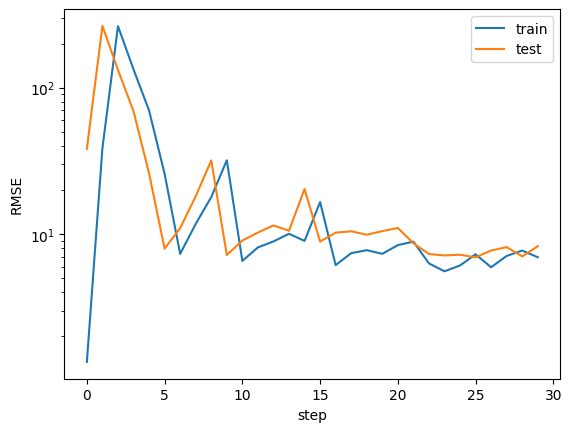

In [14]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [15]:
results['train_acc'][-1], results['test_acc'][-1]

(0.20540207624435425, 0.20177331566810608)

# Change opt to LBFGS with Scaled dataset

In [16]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 64, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=10,  # Increase steps for more training iterations
    # lamb=0.01,  # Regularization strength
    # lamb_entropy=10.0  # Entropy regularization strength
)
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.56e-01 | reg: 7.86e+02 | : 100%|█| 10/10 [00:41<00:00,  4.11s/


saving model version 0.1


In [8]:
results['train_acc'][-1], results['test_acc'][-1]

(0.971038281917572, 0.9700455665588379)

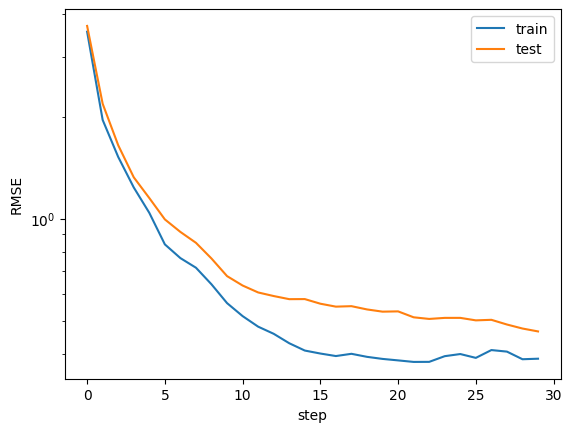

In [7]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [19]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 128, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=10,  # Increase steps for more training iterations
    # lamb=0.01,  # Regularization strength
    # lamb_entropy=10.0  # Entropy regularization strength
)
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.85e-02 | test_loss: 3.76e-01 | reg: 2.10e+03 | : 100%|█| 10/10 [01:17<00:00,  7.74s/


saving model version 0.1


(0.9984594583511353, 0.9925712943077087)

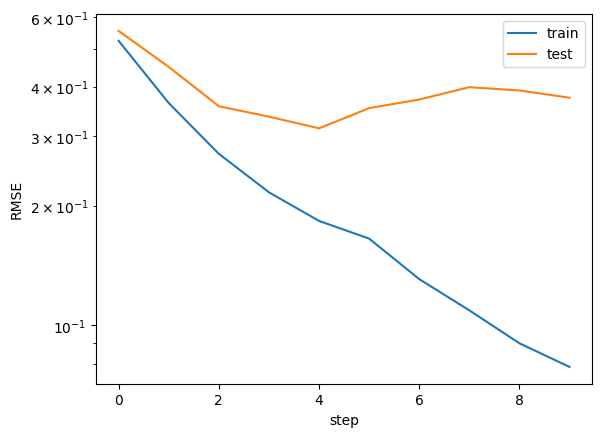

In [20]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.44e-01 | reg: 7.55e+02 | : 100%|█| 6/6 [00:25<00:00,  4.30s/it


saving model version 0.1


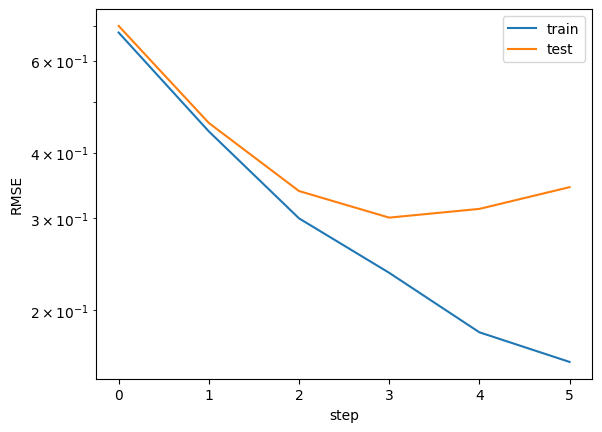

In [18]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 32, 16, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=6,  # Increase steps for more training iterations
    # lamb=1.,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)
results['train_acc'][-1], results['test_acc'][-1]
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e-01 | test_loss: 3.63e-01 | reg: 8.44e+02 | : 100%|█| 5/5 [00:07<00:00,  1.57s/it


saving model version 0.1
0.9914758205413818 0.98969566822052


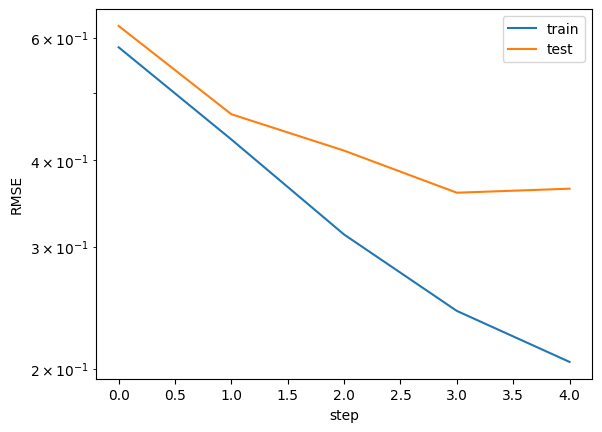

In [7]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=5,  # Increase steps for more training iterations
    # lamb=1.,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)
print(results['train_acc'][-1], results['test_acc'][-1])
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [24]:
len(torch.unique(custom_dataset['train_label']))

6

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.38e-01 | reg: 4.38e+02 | : 100%|█| 5/5 [00:04<00:00,  1.18it/s


saving model version 0.1
0.9938379526138306 0.9906542301177979


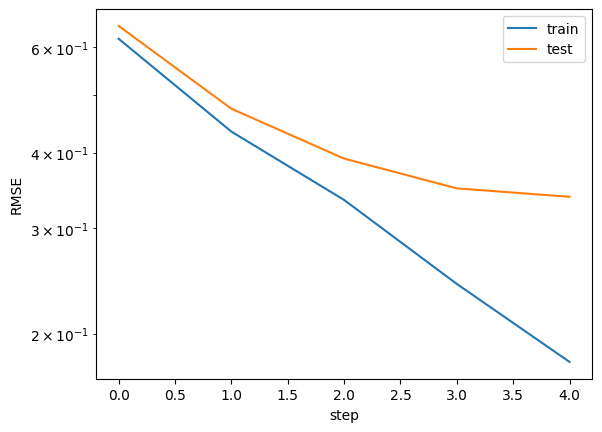

In [12]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 12, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=5,  # Increase steps for more training iterations
    # lamb=1.,  # Regularization strength
    # lamb_entropy=10.0  # Entropy regularization strength
)
print(results['train_acc'][-1], results['test_acc'][-1])
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 12, len(torch.unique(custom_dataset['train_label']))], grid=3, k=3
)

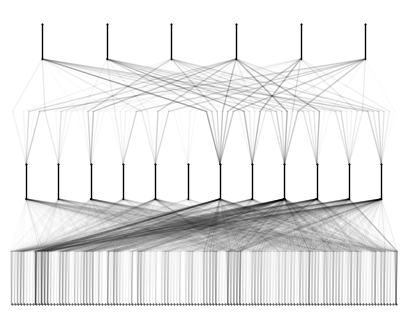

In [13]:
model.plot()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.16e-01 | reg: 8.92e+02 | : 100%|█| 5/5 [00:10<00:00,  2.19s/it


saving model version 0.1
0.9957892298698425 0.9918524026870728


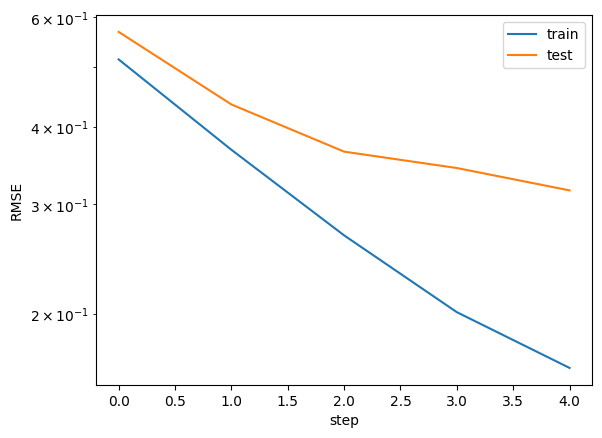

In [7]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=5,  # Increase steps for more training iterations
    # lamb=1.,  # Regularization strength
    # lamb_entropy=10.0  # Entropy regularization strength
)
print(results['train_acc'][-1], results['test_acc'][-1])
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.06e-01 | test_loss: 3.08e-01 | reg: 1.00e+03 | : 100%|█| 8/8 [00:04<00:00,  1.74it/s


saving model version 0.1
0.9975351691246033 0.9935298562049866


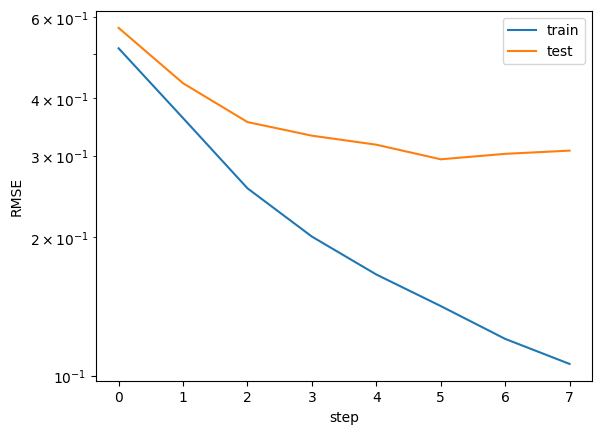

In [10]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=8,  # Increase steps for more training iterations
    # lamb=1.,  # Regularization strength
    # lamb_entropy=10.0  # Entropy regularization strength
)
print(results['train_acc'][-1], results['test_acc'][-1])
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

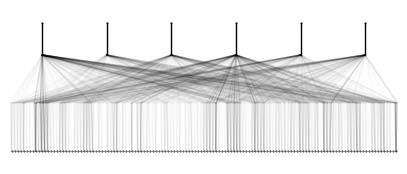

In [11]:
model.plot()

In [14]:
model.feature_score

tensor([1.1578e-01, 6.0887e-02, 1.1677e-01, 1.5391e-01, 1.1919e-01, 3.5377e-02,
        2.6590e-02, 2.4823e-02, 3.8287e-01, 1.0283e-01, 2.8751e-01, 2.3077e-01,
        2.0839e-01, 6.1343e-02, 3.3965e-02, 2.3237e-02, 1.2785e-01, 1.4472e-01,
        1.0727e-01, 7.6569e-02, 1.2268e-02, 7.9083e-02, 6.3398e-02, 5.9387e-02,
        1.4080e-01, 1.2434e-01, 1.0608e-01, 1.4270e-01, 1.9658e-02, 9.0241e-02,
        3.1625e-02, 7.0057e-03, 1.5784e-01, 4.0131e-02, 1.5644e-01, 1.2053e-01,
        5.8853e-02, 3.0571e-02, 1.7021e-02, 2.0081e-02, 1.1022e-01, 1.6138e-04,
        1.3450e-01, 1.3667e-01, 6.9849e-02, 2.8126e-02, 4.1276e-02, 1.7794e-02,
        4.8394e-02, 1.8400e-03, 4.9522e-02, 1.0013e-01, 1.0472e-01, 2.9460e-02,
        3.0600e-02, 2.4554e-02, 5.9547e-02, 9.0202e-04, 5.1871e-02, 8.5357e-02,
        1.1171e-01, 3.0793e-02, 2.7971e-02, 2.2584e-02, 1.2300e-01, 9.9907e-02,
        1.2008e-01, 1.2219e-01, 1.7756e-01, 4.3918e-02, 2.3711e-02, 2.0827e-02,
        2.2940e-01, 1.2411e-01, 1.5001e-

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.40e-01 | test_loss: 4.24e-01 | reg: 2.26e+02 | : 100%|█| 8/8 [00:09<00:00,  1.22s/it


saving model version 0.1
0.9879840016365051 0.9872993230819702


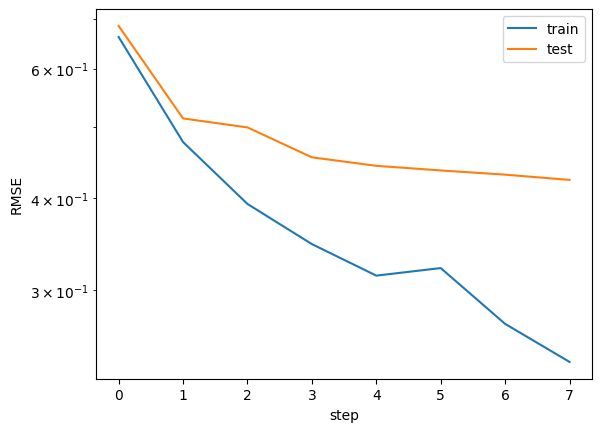

In [20]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 3, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=8,  # Increase steps for more training iterations
    #lamb=-1,  # Regularization strength
    #lamb_l1=0.001  # Entropy regularization strength
)
print(results['train_acc'][-1], results['test_acc'][-1])
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')